In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle
import random
import cv2

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

np.random.seed(0)

In [21]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

print(type(train_data))

x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']



<class 'dict'>


In [22]:
print(x_train.shape)#34799 images 32*32 pixels with depth of 3
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [23]:
assert (x_train.shape[0] == y_train.shape[0]), 'The number of images is not equal to the number of labels'
assert (x_val.shape[0] == y_val.shape[0]), 'The number of images is not equal to the number of labels'
assert (x_test.shape[0] == y_test.shape[0]), 'The number of images is not equal to the number of labels'

assert(x_train.shape[1: ] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(x_val.shape[1: ] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(x_test.shape[1: ] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'

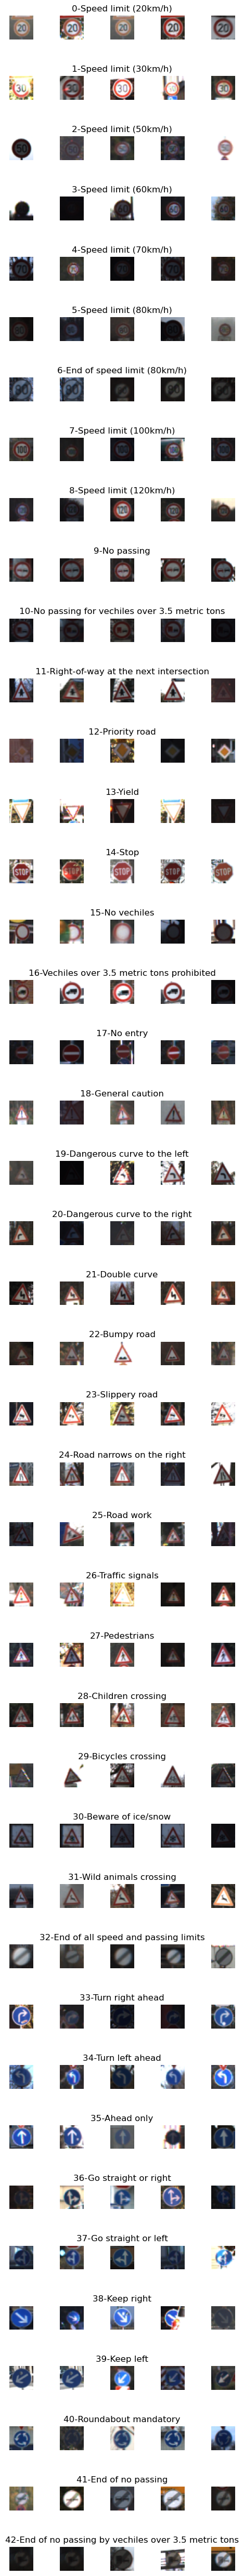

In [24]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ '-' + row['SignName'])
            num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

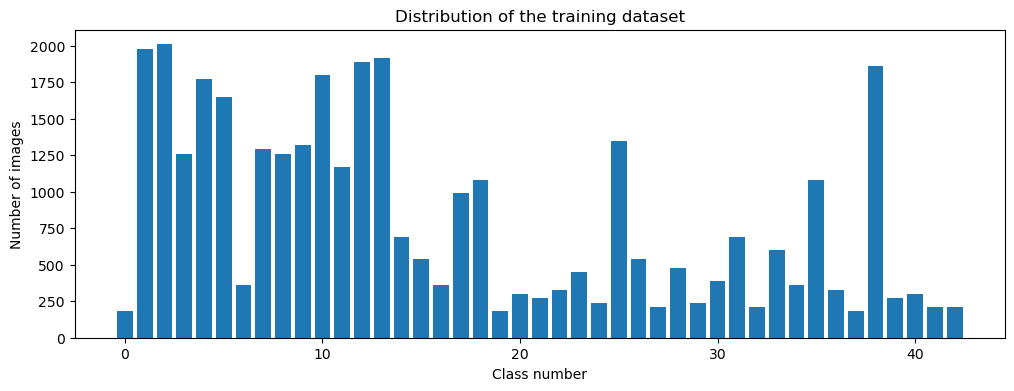

In [25]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")


(32, 32, 3)
36


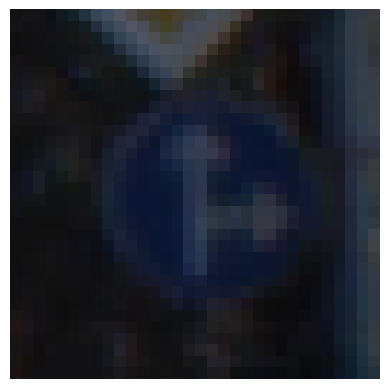

In [26]:
plt.imshow(x_train[1000], interpolation='none')
plt.axis('off')
print(x_train[1000].shape)
print(y_train[1000])

(32, 32)


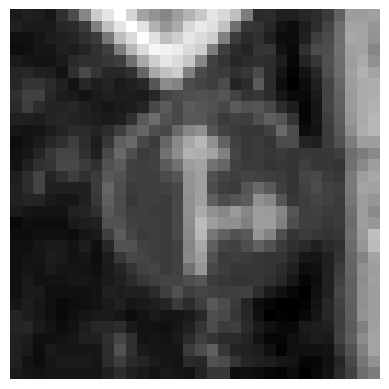

In [27]:
def gray_scale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = gray_scale(x_train[1000])
plt.imshow(img, cmap='gray', interpolation='none')
plt.axis('off')
print(img.shape)


(32, 32)


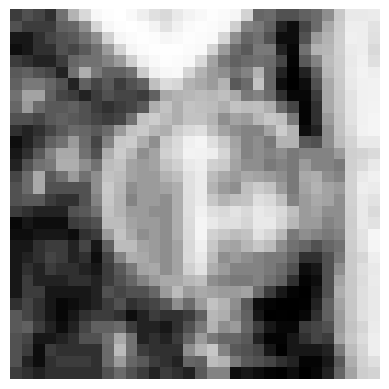

In [28]:
def equalize(img):#only accepts gray scale images
    img = cv2.equalizeHist(img)#only accepts gray scale images
    return img

img = equalize(gray_scale(x_train[1000]))
plt.imshow(img, cmap='gray', interpolation='none')
plt.axis('off')
print(img.shape)

In [29]:
def preprocessing(img):
    img = gray_scale(img)
    img = equalize(img)
    img = img/255
    return img

x_train = np.array(list(map(preprocessing, x_train)))
x_val = np.array(list(map(preprocessing, x_val)))
x_test = np.array(list(map(preprocessing, x_test)))


(34799, 32, 32)


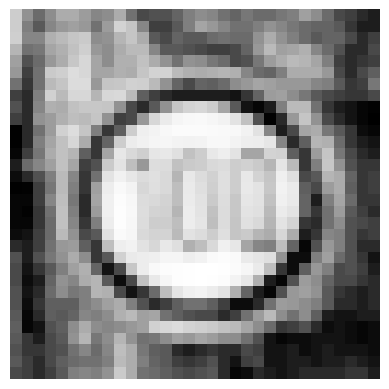

In [30]:
plt.imshow(x_train[random.randint(0, (len(x_train) - 1))], cmap='gray', interpolation='none')
plt.axis('off')
print(x_train.shape)

In [31]:
x_train = x_train.reshape(34799, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)

In [32]:
#data ogmentation process
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,# in 1.2 , out 0.8
)
datagen.fit(x_train)

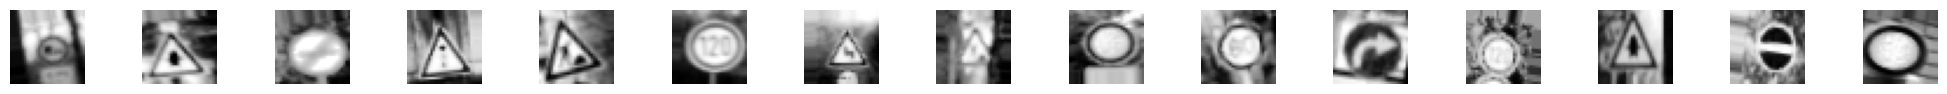

In [33]:
batches = datagen.flow(x_train, y_train, batch_size = 20)# starting the process flowing of augmented data from the generator in batches of 20
x_batch, y_batch = next(batches)

fig, axs = plt.subplots(1 ,15 ,figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(x_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))
    axs[i].axis('off')

In [34]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [35]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [36]:
def modified_model():
    model =Sequential()
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))    
    model.add(MaxPooling2D(pool_size = (2, 2)))
    #model.add(Dropout(0.5))

    
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics = ['accuracy'])
    return model

In [37]:
model = modified_model()
print(model.summary())

c:\Users\3omd4\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(x_val, y_val), shuffle = 1)

Epoch 1/10


c:\Users\3omd4\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 696/2000 ━━━━━━━━━━━━━━━━━━━━ 1:18 60ms/step - accuracy: 0.2850 - loss: 2.6252

c:\Users\3omd4\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 22ms/step - accuracy: 0.4274 - loss: 2.0561 - val_accuracy: 0.9184 - val_loss: 0.2781
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.8303 - loss: 0.5439 - val_accuracy: 0.9565 - val_loss: 0.1404
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.8961 - loss: 0.3375 - val_accuracy: 0.9791 - val_loss: 0.0710
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.9249 - loss: 0.2437 - val_accuracy: 0.9805 - val_loss: 0.0662
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.9371 - loss: 0.2015 - val_accuracy: 0.9816 - val_loss: 0.0565
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9470 - loss: 0.1752 - val_accuracy: 0.9812 - val_loss: 0.0583
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.9509 - loss: 0.1572 - val_accuracy: 0.9825 - val_loss: 0.0658
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.9562 - loss: 0.13

Text(0.5, 0, 'epochs')

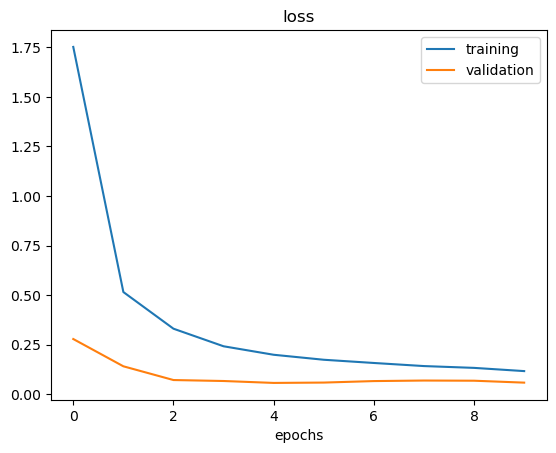

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

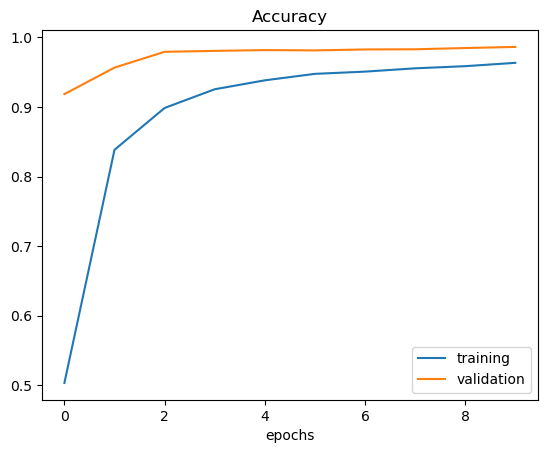

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epochs')

In [41]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.1400933712720871
Test Accuracy: 0.9669833779335022


In [42]:
import requests
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

def preprocessing(img):
    # Add your preprocessing steps here
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0  # Normalize the image
    return img

def TEST(url):
    r = requests.get(url, stream=True)
    img = Image.open(r.raw)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()

    img = np.asarray(img)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()
    print(img.shape)

    img = img.reshape(1, 32, 32, 1)

    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)
    print("predicted sign: " + str(predicted_class))
    return img

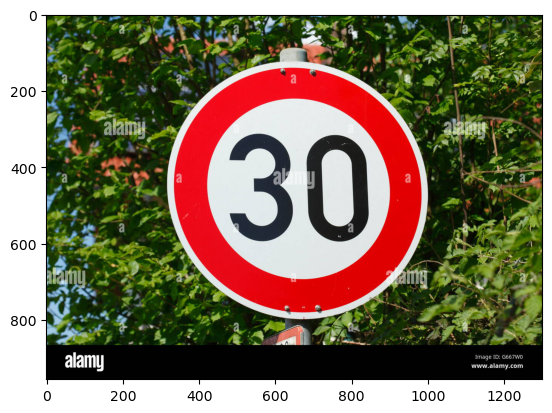

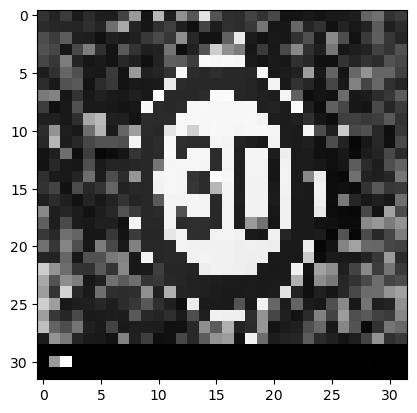

(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
predicted sign: [1]


In [43]:
url ='https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
img = TEST(url)

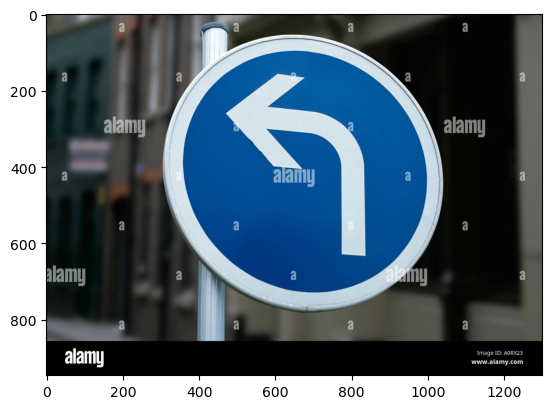

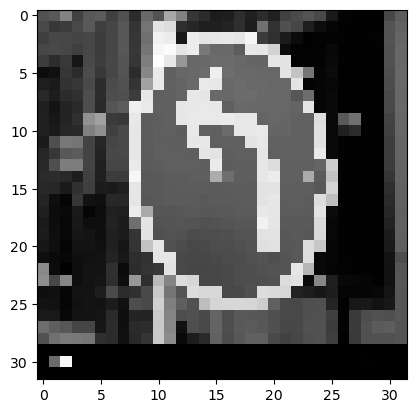

(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
predicted sign: [34]


In [44]:
url ="https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg"
img = TEST(url)

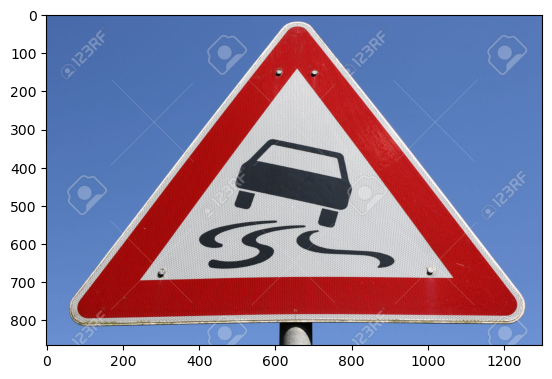

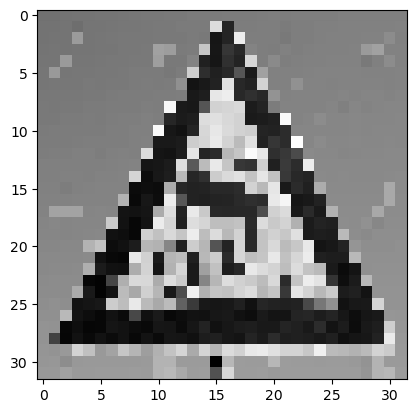

(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
predicted sign: [23]


In [45]:
url ="https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg"
img = TEST(url)

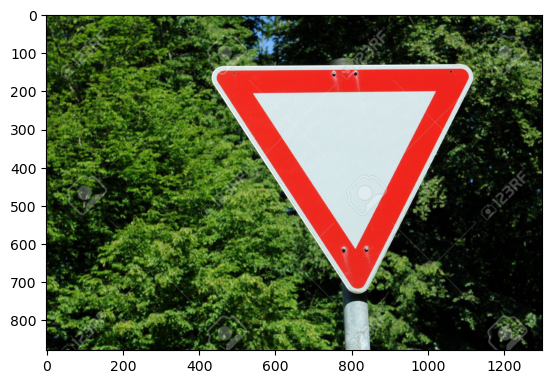

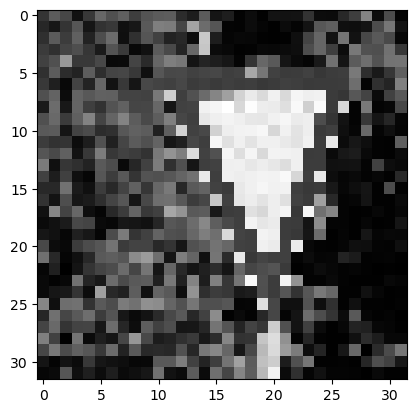

(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
predicted sign: [13]


In [46]:
url ="https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg"
img = TEST(url)

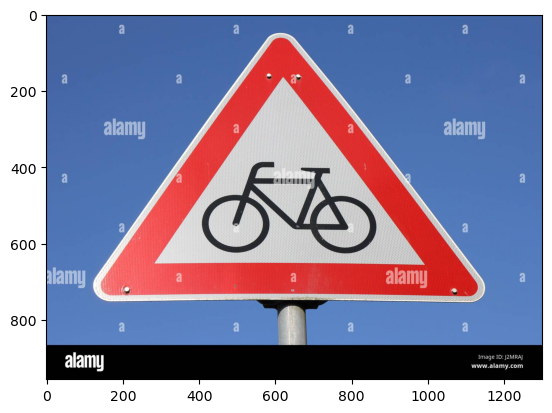

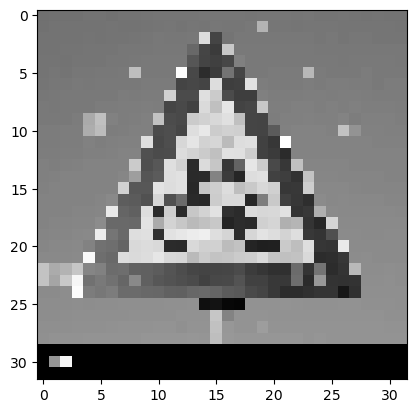

(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
predicted sign: [29]


In [47]:
url ="https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg"
img = TEST(url)